In [ ]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
plt.close("all")

PATH="C:/Users/..."
os.chdir(PATH)
print("Current working directory -->", PATH)

In [2]:
'''
Working factors
---------------

Period: 01-01-2020 to 31-12-2020
Frequence: daily prices
Website: Yahoo Finance
Risk factors: SPY, TLT, GLD and S&P 500

For this exercise, the S&P 500 will be our benchmark.

'''
SPY=pd.read_csv("SPY.csv", infer_datetime_format=True) # Constitutent 1
TLT=pd.read_csv("TLT.csv", infer_datetime_format=True) # Constitutent 2
GLD=pd.read_csv("GLD.csv", infer_datetime_format=True) # Constitutent 3
SP500=pd.read_csv("SP500.csv", infer_datetime_format=True) # Benchmark

factors_dict = {
    'SPY': SPY,
    'TLT': TLT,
    'GLD': GLD,
    'SP500': SP500,
}

factors_dict['SPY'].head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,323.540009,324.890015,322.529999,324.869995,318.914307,59151200
1,2020-01-03,321.160004,323.640015,321.100006,322.410004,316.499451,77709700
2,2020-01-06,320.489990,323.730011,320.359985,323.640015,317.706909,55653900


In [3]:
# Selecting the 'Adj Close' as it adjust for, e.g. stock splits
# Renaming the 'Adj Close'
for k in factors_dict.keys():
    factors_dict[k] = factors_dict[k].rename(columns={"Adj Close": k})
    
factors_dict['SPY'].head(3)

,Date,Open,High,Low,Close,SPY,Volume
0,2020-01-02,323.540009,324.890015,322.529999,324.869995,318.914307,59151200
1,2020-01-03,321.160004,323.640015,321.100006,322.410004,316.499451,77709700
2,2020-01-06,320.489990,323.730011,320.359985,323.640015,317.706909,55653900


In [4]:
# Joining all factors in one table
master_factors = factors_dict['SPY'][["Date"]]
for k in factors_dict.keys():
    master_factors = pd.merge(
        master_factors,
        factors_dict[k][["Date", k]],
        how='left',
        on=["Date"]
    )
    
master_factors.head(3)

,Date,SPY,TLT,GLD,SP500
0,2020-01-02,318.914307,135.004837,143.949997,3257.850098
1,2020-01-03,316.499451,137.083969,145.860001,3234.850098
2,2020-01-06,317.706909,136.305542,147.389999,3246.280029


In [5]:
# Set 'Date' column to index
master_factors['Date'] = pd.to_datetime(master_factors['Date'], infer_datetime_format=True)
master_factors = master_factors.set_index('Date')

master_factors.head(3)

,SPY,TLT,GLD,SP500
Date,,,,
2020-01-02,318.914307,135.004837,143.949997,3257.850098
2020-01-03,316.499451,137.083969,145.860001,3234.850098
2020-01-06,317.706909,136.305542,147.389999,3246.280029


In [6]:
'''
Compute the returns

Important reminder:

    1. Simple returns are additive in a portfolio but not log returns
    2. Simple returns are not additive over time
    3. Arithmetic mean provides an unbiased estimate of the return for the following period.
    4. Geometric mean is a good measure of the historical performance.

'''

for k in master_factors.keys():
    master_factors['ret_' + k] = (master_factors[k] - master_factors[k].shift(1))/master_factors[k].shift(1)

master_returns = master_factors[[c for c in master_factors.columns if c.startswith("ret_")]]\
                                .dropna()

# Round to 5 decimals
master_returns = master_returns.round(5)

master_returns.head(3)

,ret_SPY,ret_TLT,ret_GLD,ret_SP500
Date,,,,
2020-01-03,-0.00757,0.01540,0.01327,-0.00706
2020-01-06,0.00382,-0.00568,0.01049,0.00353
2020-01-07,-0.00281,-0.00492,0.00394,-0.00280


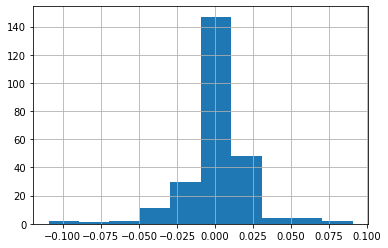

In [7]:
# Intermediary quick check
# Stock returns are NOT normally distributed as they have ticker tails and are negatively skewed.
master_returns['ret_SPY'].hist()

In [8]:
# Computing the portfolio returns with weights SPY:0.5, GLD:0.4, TLT:0.1
portfolio_w = {
    'ret_SPY': 0.5,
    'ret_GLD': 0.4,
    'ret_TLT': 0.1
}

master_returns["rp"]=0
for k, v in portfolio_w.items():
    master_returns["rp"] += v * master_returns[k]
    
master_returns.head(3)

,ret_SPY,ret_TLT,ret_GLD,ret_SP500,rp
Date,,,,,
2020-01-03,-0.00757,0.01540,0.01327,-0.00706,0.003063
2020-01-06,0.00382,-0.00568,0.01049,0.00353,0.005538
2020-01-07,-0.00281,-0.00492,0.00394,-0.00280,-0.000321


In [9]:
'''
Jensen's alpha formula: rp - Rf =  ALPHA + Beta*(rb – Rf)

rp: portfolio returns
Rf: risk free rate here assumed to be equal to zero for simplicity
ALPHA: OLS intercept
rb: benchmark returns
'''

X_train = master_returns[["ret_SP500"]] # Benchmark returns
X_train["alpha"] = 1 # Our model needs an intercept so we add a column of 1s
y_train = master_returns[["rp"]] # portfolio returns

# Fit and summarize OLS model
mod = sm.OLS(y_train, X_train)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     rp   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     982.6
Date:                Thu, 11 Feb 2021   Prob (F-statistic):           2.07e-88
Time:                        22:02:12   Log-Likelihood:                 956.18
No. Observations:                 251   AIC:                            -1908.
Df Residuals:                     249   BIC:                            -1901.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
ret_SP500      0.4903      0.016     31.346      0.0

<ipython-input-9-09648bc387c7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["alpha"] = 1 # Our model needs an intercept so we add a column of 1s


In [10]:
'''
Summary interpretation
----------------------

1) The constant coefficient (alpha) is statistically not significant as the P-value (0.165) is greater than 0.05
2) The Beta of our exogene variable (S&P 500) is satistically significant since the P-value (0.000) is smaller than 0.05
3) The return of our portfolio is predicted to increase by 0.4903 when the S&P 500 variable goes up by one unit

'''


'\nSummary interpretation\n----------------------\n\n1) The constant coefficient (alpha) is statistically not significant as the P-value (0.165) is greater than 0.05\n2) The Beta of our exogene variable (S&P 500) is satistically significant since the P-value (0.000) is smaller than 0.05\n3) The return of our portfolio is predicted to increase by 0.4903 when the S&P 500 variable goes up by one unit\n\n'

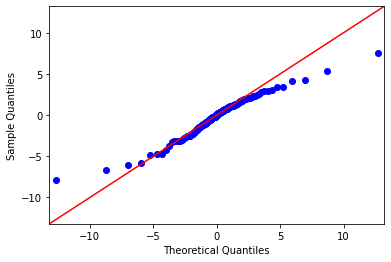

In [11]:
# Q-Q plot of the residuals against quantiles of t-distribution
fig = sm.qqplot(res.resid , stats.t, fit=True, line="45")
plt.show()

-------- Cumulative returns for year 2020 --------
Portfolio:  21.75 %
Benchmark:  14.56 %


<Figure size 864x1152 with 0 Axes>

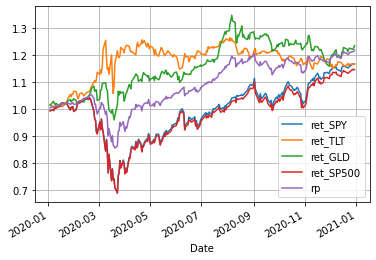

In [12]:
# Cumulative sum
df_cumsum = (1 + master_returns).cumprod()

p_annual_ret = df_cumsum['rp'].iloc[-1] - 1
bm_annual_ret = df_cumsum['ret_SP500'].iloc[-1] - 1

plt.figure(figsize=(12, 16))
df_cumsum.plot()
plt.grid(True)

print('-------- Cumulative returns for year 2020 --------')
print('Portfolio: ', round(p_annual_ret * 100, 2), "%")
print('Benchmark: ', round(bm_annual_ret * 100, 2), "%")

<Figure size 864x1152 with 0 Axes>

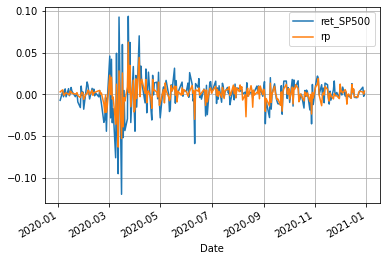

In [13]:
# Time series returns
df_rets = master_returns[["ret_SP500", "rp"]]

plt.figure(figsize=(12, 16))
df_rets.plot()
plt.grid(True)

In [14]:
###################################################
#### Technical information ########################

# Tracking Error (TE)
# Volatility
# Correlation
# Beta

# Note: the benchmarks returns is in this exercise 'log_SP500'

In [15]:
# TE
master_returns['TE_1'] = (master_returns['rp'] - master_returns['ret_SP500'])**2
TE =  master_returns['TE_1'].sum()
TE = TE/(len(master_returns) - 1)
TE = TE**0.5

In [16]:
# Correlation
p_corr = master_returns['rp'].corr(master_returns['ret_SP500'])

In [17]:
# Volatility
weights = np.array(list(portfolio_w.values()))
factor_cov = master_returns[['ret_SPY', 'ret_TLT', 'ret_GLD']].cov()

p_vol = np.sqrt(np.dot(weights.T, np.dot(factor_cov * len(master_returns), weights)))

In [18]:
print('---- Technical Information ----')
print('Volatility: ', round(p_vol * 100, 2), "%")
print('TE: ', round(TE * 100, 2))
print('Correlation: ', round(p_corr, 2))
print('Beta: ', round(res.params[0], 2))

---- Technical Information ----
Volatility:  15.37 %
TE:  1.23
Correlation:  0.89
Beta:  0.49
